<a href="https://colab.research.google.com/github/rosanavanesavasquez/GameSpeak/blob/main/GameSpeak_NLP_Insights_from_Gamer_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción


## Introducción al Problema

Steam recibe miles de reseñas diarias sobre sus juegos.
Estas opiniones representan una fuente rica para entender la experiencia real de los jugadores.
Sin embargo, su análisis manual es inviable a gran escala.

## Objetivo:
Construir un modelo que permita clasificar automáticamente las reseñas de juegos como positivas o negativas, aprovechando técnicas de procesamiento de lenguaje natural (NLP) y deep learning.


## 📄 Descripción del Dataset
El dataset seleccionado contiene información detallada de más de 110.000 videojuegos publicados en la plataforma Steam. Cada fila representa un videojuego individual, incluyendo variables de tipo numérico, categórico y de texto libre.

## 🧩 Variables relevantes
Algunas de las columnas más significativas incluyen:

Name: Nombre del videojuego.

About the game: Descripción del juego (texto libre ideal para NLP).

Supported languages, Categories, Genres, Tags: Listados de características categóricas.

Reviews: Opiniones de usuarios (aunque con muchos valores faltantes).

Price, User score, Metacritic score: Métricas de valoración y comercialización.

Recommendations, Achievements, Playtime: Métricas de uso.

## 📊 Tamaño y estructura
Total de registros: 111.452 juegos

Columnas: 39

Presencia de valores faltantes en algunas columnas como Reviews, Website, Support email, lo que puede requerir preprocesamiento adicional.

https://www.kaggle.com/datasets/arashnic/game-review-dataset


# Librerías


In [2]:
# Instalación de librerías necesarias
!pip install -q chardet
!python -m spacy download es_core_news_md

# -------------------------------
# Librerías estándar
import re
import string
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Manejo de datos y análisis
import pandas as pd
import numpy as np

# -------------------------------
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# -------------------------------
# NLP - spaCy & NLTK
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# -------------------------------
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Imports

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 17.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Lectura de la Base de Datos


In [3]:
# Montamos en Google Drive en Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Definimos las rutas a los archivos ya descomprimidos en Drive
train_reviews_path = "/content/gdrive/MyDrive/CODER HOUSE/DATA_SET/Steam Game Review Dataset/review/train_gr/train.csv"
test_reviews_path = "/content/gdrive/MyDrive/CODER HOUSE/DATA_SET/Steam Game Review Dataset/review/test_gr/test.csv"
games_csv_path = "/content/gdrive/MyDrive/CODER HOUSE/DATA_SET/Steam Game Review Dataset/games/games.csv"

# Leemos los archivos
train_df = pd.read_csv(train_reviews_path)
test_df = pd.read_csv(test_reviews_path)
games_df = pd.read_csv(games_csv_path)

# Vista previa
train_df.head()
test_df.head(10)
games_df.head(10)


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1469160,Wartune Reborn,"Feb 26, 2021",50000 - 100000,68,0,0.00,0,0,Feel tired of auto-fight? Feel tired of boring...,['English'],...,0,0,0,7Road,7Road,"Single-player,Multi-player,MMO,PvP,Online PvP,...","Adventure,Casual,Free to Play,Massively Multip...","Turn-Based Combat,Massively Multiplayer,Multip...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1659180,TD Worlds,"Jan 9, 2022",0 - 20000,3,0,10.99,0,1,"TD Worlds is a dynamic, highly strategical gam...","['English', 'Russian', 'Danish']",...,0,0,0,MAKSIM VOLKAU,MAKSIM VOLKAU,"Single-player,Steam Achievements,Steam Cloud","Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1968760,Legend of Rome - The Wrath of Mars,"May 5, 2022",0 - 20000,2,0,9.99,0,0,When the Roman people honored a simple warrior...,"['English', 'German']",...,0,0,0,magnussoft,magnussoft,"Single-player,Steam Cloud",Casual,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1178150,MazM: Jekyll and Hyde,"Apr 2, 2020",0 - 20000,1,0,14.99,0,0,'MazM: Jekyll and Hyde' is a darkly entertaini...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Growing Seeds,"CFK Co., Ltd.","Single-player,Steam Achievements,Full controll...","Adventure,RPG,Simulation,Strategy","Adventure,Simulation,RPG,Strategy,Singleplayer...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
320150,Deadlings: Rotten Edition,"Nov 11, 2014",50000 - 100000,0,0,3.99,0,0,Death is lonely. He has zero friends on his Fa...,"['English', 'Polish', 'French', 'Italian', 'Ge...",...,0,782,0,ONE MORE LEVEL,ON

# Preprocesamiento del texto
Limpiar y normalizar el texto

Eliminar stopwords

Tokenizar

Crear una nueva columna clean_review

In [6]:
# Lista de stopwords en inglés
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Minúsculas
train_df['lowercase'] = train_df['user_review'].str.lower()

# Sin puntuación
train_df['no_punct'] = train_df['lowercase'].str.replace(r'[^a-z\s]', '', regex=True)

# Tokenización
train_df['tokens'] = train_df['no_punct'].apply(word_tokenize)

# Stopwords removidas
train_df['no_stopwords'] = train_df['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])

# Texto limpio final
train_df['clean_review'] = train_df['no_stopwords'].apply(lambda tokens: ' '.join(tokens))


In [7]:
# Vemos una selección de reseñas limpias:
train_df[['user_review', 'clean_review']].sample(15)


,user_review,clean_review
2929,Ive hade this game from wenn it kame out and i...,ive hade game wenn kame dont giv aabote haters...
1000,An excellent variety of ships with different p...,excellent variety ships different playstyles d...
2623,"Game is fun through tiers 1-3, however once ti...",game fun tiers however tier reached game becom...
5930,Never seen so many geeks in one game.I brought...,never seen many geeks one gamei brought fc ext...
6778,"Most hours spend, where in the beta. But sadly...",hours spend beta sadly final cut seems much di...
14055,Unbelievable that this rehash copy and paste t...,unbelievable rehash copy paste trash allowed s...
14868,Early Access ReviewIt's all about grinding now...,early access reviewits grinding game good bah ...
1241,Early Access ReviewThe Game is Fun but its ful...,early access reviewthe game fun full fing noob...
16659,its easy to explain ...,easy explain would play
13414,Honestly going into this I didn't think I woul...,honestly going didnt think would find game enj...


In [8]:


# Lista de stopwords en inglés
# stop_words = set(stopwords.words('english'))

# Función de limpieza
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                                  # Minúsculas
    text = re.sub(r'[^a-z\s]', '', text)                 # Eliminar caracteres especiales
    tokens = word_tokenize(text)                         # Tokenizar
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stopwords
    return ' '.join(tokens)

# Aplicamos la limpieza
train_df['clean_review'] = train_df['user_review'].apply(clean_text)

# Verificamos
train_df[['user_review', 'clean_review']].head(15)


,user_review,clean_review
0,I'm scared and hearing creepy voices. So I'll...,im scared hearing creepy voices ill pause mome...
1,"Best game, more better than Sam Pepper's YouTu...",best game better sam peppers youtube account y...
2,"A littly iffy on the controls, but once you kn...",littly iffy controls know play easy master ive...
3,"Great game, fun and colorful and all that.A si...",great game fun colorful thata side note though...
4,Not many games have the cute tag right next to...,many games cute tag right next horror tag stea...
5,"Early Access ReviewIt's pretty cute at first, ...",early access reviewits pretty cute first later...
6,Great game. it's a cute little horror game tha...,great game cute little horror game progressive...
7,Spooky's Jump Scare Mansion is a Free Retro ma...,spookys jump scare mansion free retro maze gam...
8,"Somewhere between light hearted, happy parody ...",somewhere light hearted happy parody afraid da...
9,This game with its cute little out of the wall...,game cute little wall popups scared living lig...


# Vectorización TF-IDF + Modelo Base

 Vectorización del texto con TF-IDF y entrenamiento de un modelo base de clasificación.

Usaremos:

1) TfidfVectorizer para transformar clean_review a vectores numéricos.

2) LogisticRegression como modelo de clasificación binaria (0 = no recomendado, 1 = recomendado).

3) Métricas: Accuracy, F1-Score, matriz de confusión.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(train_df['clean_review'])
y = train_df['user_suggestion']

# División en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_val)


# Evaluación del Modelo

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1473
           1       0.86      0.89      0.88      2026

    accuracy                           0.85      3499
   macro avg       0.85      0.85      0.85      3499
weighted avg       0.85      0.85      0.85      3499



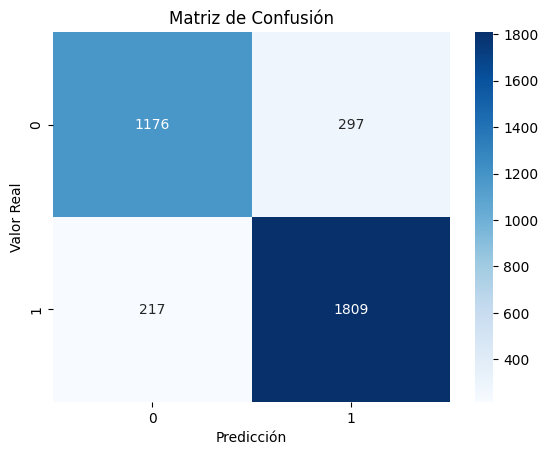

In [10]:
# Métricas de desempeño
print(classification_report(y_val, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


## Resumen del rendimiento del modelo
Accuracy general: 0.85
Las clases están balanceadas, no hay sesgo evidente.

##Interpretación:

El modelo identifica muy bien las reseñas positivas (clase 1), con alta precisión y recall.

Las negativas también las capta bastante bien, aunque con un poco más de error.

# Análisis exploratorio (NLP)

Nube de palabras general

Nube de palabras según clase (user_suggestion 0 o 1)

Palabras más frecuentes por clase



In [11]:
!pip install wordcloud


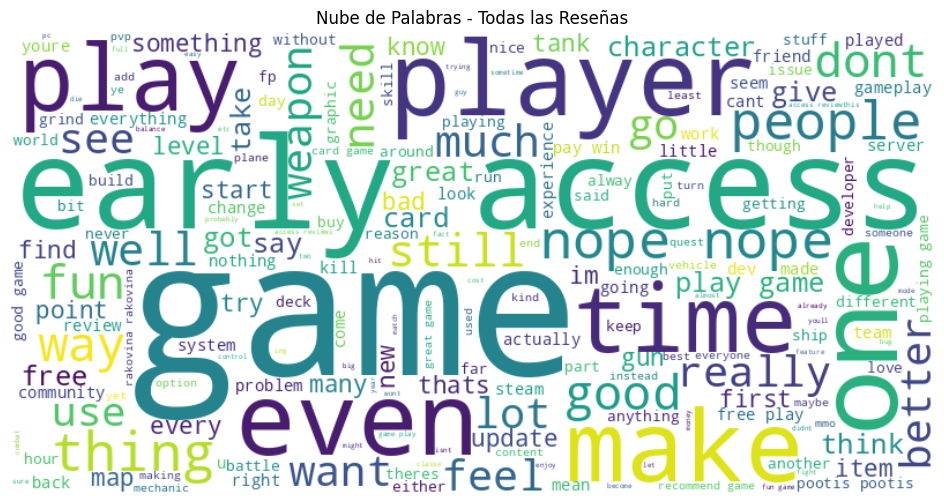

In [12]:
from wordcloud import WordCloud

# Texto combinado
all_words = ' '.join(train_df['clean_review'])

# Generar nube
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Mostrar
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras - Todas las Reseñas")
plt.show()


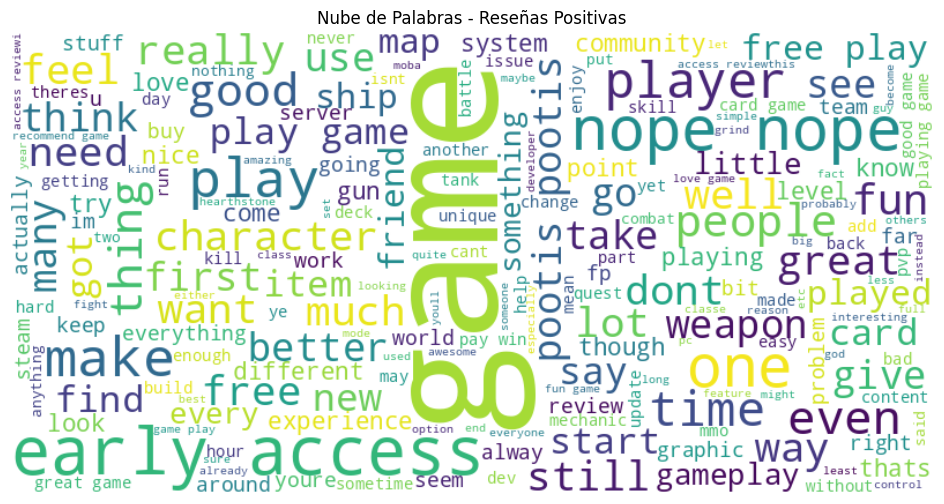

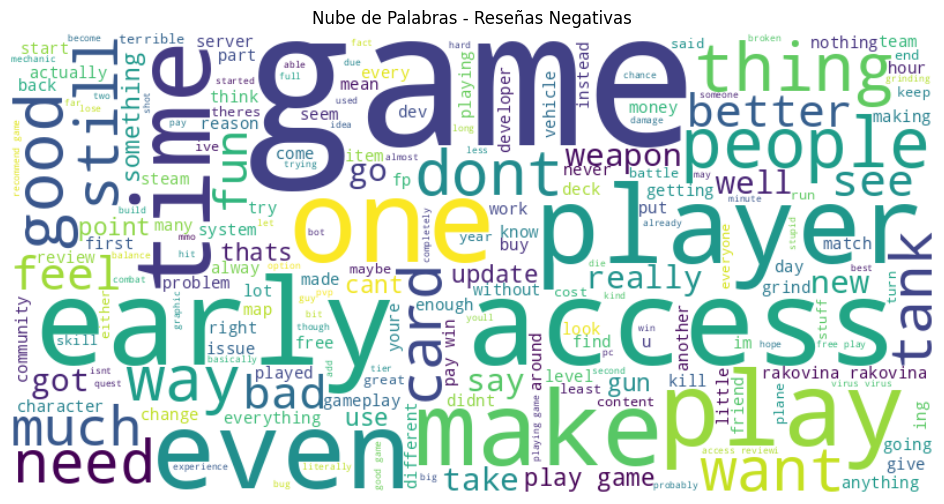

In [13]:
#WordCloud por clase (positivo vs negativo)
# Recomendadas (user_suggestion == 1)
pos_words = ' '.join(train_df[train_df['user_suggestion'] == 1]['clean_review'])

# No recomendadas (user_suggestion == 0)
neg_words = ' '.join(train_df[train_df['user_suggestion'] == 0]['clean_review'])

# WordCloud positiva
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_words)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras - Reseñas Positivas")
plt.show()

# WordCloud negativa
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_words)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras - Reseñas Negativas")
plt.show()


## Análisis de las nubes de palabras

"nope", "early access", "play", "game" se repiten pero con contexto diferente.

Palabra ambigua: nope
Aparece en ambas nubes, pero probablemente con polaridad negativa en ambos casos. Puede que haya reseñas cínicas o irónicas que fueron clasificadas como 1

In [14]:
#Crear DataFrames de frecuencia por clase
from collections import Counter
import pandas as pd

# Crear listas de palabras por clase
pos_tokens = ' '.join(train_df[train_df['user_suggestion'] == 1]['clean_review']).split()
neg_tokens = ' '.join(train_df[train_df['user_suggestion'] == 0]['clean_review']).split()

# Contar frecuencia
pos_freq = Counter(pos_tokens).most_common(15)
neg_freq = Counter(neg_tokens).most_common(15)

# Convertir a DataFrames
df_pos = pd.DataFrame(pos_freq, columns=['word', 'freq_pos'])
df_neg = pd.DataFrame(neg_freq, columns=['word', 'freq_neg'])


In [15]:
# Unir por palabra
merged_freq = pd.merge(df_pos, df_neg, on='word', how='outer').fillna(0)

# Convertir a enteros
merged_freq['freq_pos'] = merged_freq['freq_pos'].astype(int)
merged_freq['freq_neg'] = merged_freq['freq_neg'].astype(int)

# Agregar columna para diferencia
merged_freq['diff'] = merged_freq['freq_pos'] - merged_freq['freq_neg']

# Ordenar por diferencia absoluta para ver polarización
merged_freq['abs_diff'] = merged_freq['diff'].abs()
merged_freq = merged_freq.sort_values(by='abs_diff', ascending=False)


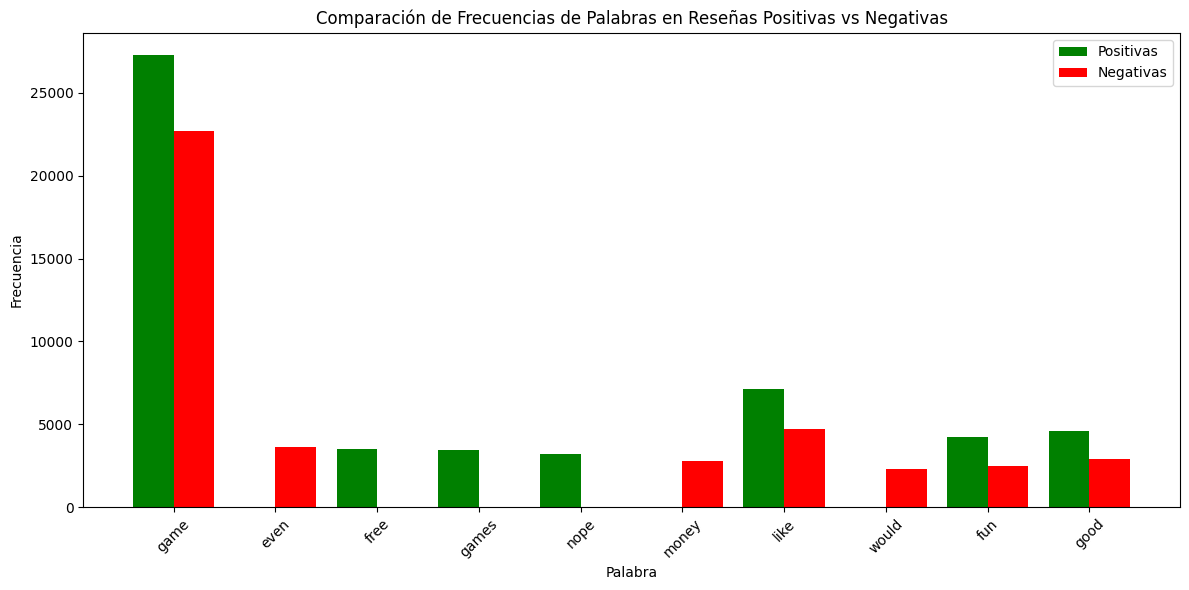

In [18]:
import matplotlib.pyplot as plt

# Seleccionar las 10 palabras más polarizadas
top_words = merged_freq.head(10)

# Plot
plt.figure(figsize=(12,6))
bar_width = 0.4
x = range(len(top_words))

plt.bar(x, top_words['freq_pos'], width=bar_width, label='Positivas', color='green')
plt.bar([i + bar_width for i in x], top_words['freq_neg'], width=bar_width, label='Negativas', color='red')

plt.xticks([i + bar_width/2 for i in x], top_words['word'], rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Comparación de Frecuencias de Palabras en Reseñas Positivas vs Negativas')
plt.legend()
plt.tight_layout()
plt.show()


## Análisis de frecuencia de palabras
observando los resultados de las palabras que se repiten, voy a trabajar con algunas de ellas que afectan mi resultado y no están categorizadas correctamente para ayudar en mi análisis.

game ; games = se usa en ambos comentarios, por lo que voy a trabajarlo con agruparlo aplicando stemming o lematización.

nope	Aparece en ambas clases, pero en general se asocia más a tono irónico o sarcástico.

In [19]:
import spacy
from tqdm import tqdm  # Para mostrar progreso

nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens_list(token_list, batch_size=1000):
    lemmas = []
    for i in tqdm(range(0, len(token_list), batch_size)):
        batch = token_list[i:i+batch_size]
        doc = nlp(' '.join(batch))
        lemmas += [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return lemmas

# Aplicar de forma segura y en lotes
pos_lemmas = lemmatize_tokens_list(pos_tokens)
neg_lemmas = lemmatize_tokens_list(neg_tokens)


100%|██████████| 567/567 [01:37<00:00,  5.83it/s]


In [20]:
#Contar lemas por clase

from collections import Counter
import pandas as pd

# Contar frecuencia de lemas
pos_lemma_counts = Counter(pos_lemmas).most_common(15)
neg_lemma_counts = Counter(neg_lemmas).most_common(15)

# Convertir a DataFrames
df_pos_lemmas = pd.DataFrame(pos_lemma_counts, columns=['word', 'freq_pos'])
df_neg_lemmas = pd.DataFrame(neg_lemma_counts, columns=['word', 'freq_neg'])

# Unir por palabra
merged_lemmas = pd.merge(df_pos_lemmas, df_neg_lemmas, on='word', how='outer').fillna(0)
merged_lemmas['freq_pos'] = merged_lemmas['freq_pos'].astype(int)
merged_lemmas['freq_neg'] = merged_lemmas['freq_neg'].astype(int)

# Diferencia
merged_lemmas['diff'] = merged_lemmas['freq_pos'] - merged_lemmas['freq_neg']
merged_lemmas['abs_diff'] = merged_lemmas['diff'].abs()

# Seleccionar las más polarizadas
top_lemmas = merged_lemmas.sort_values(by='abs_diff', ascending=False).head(10)


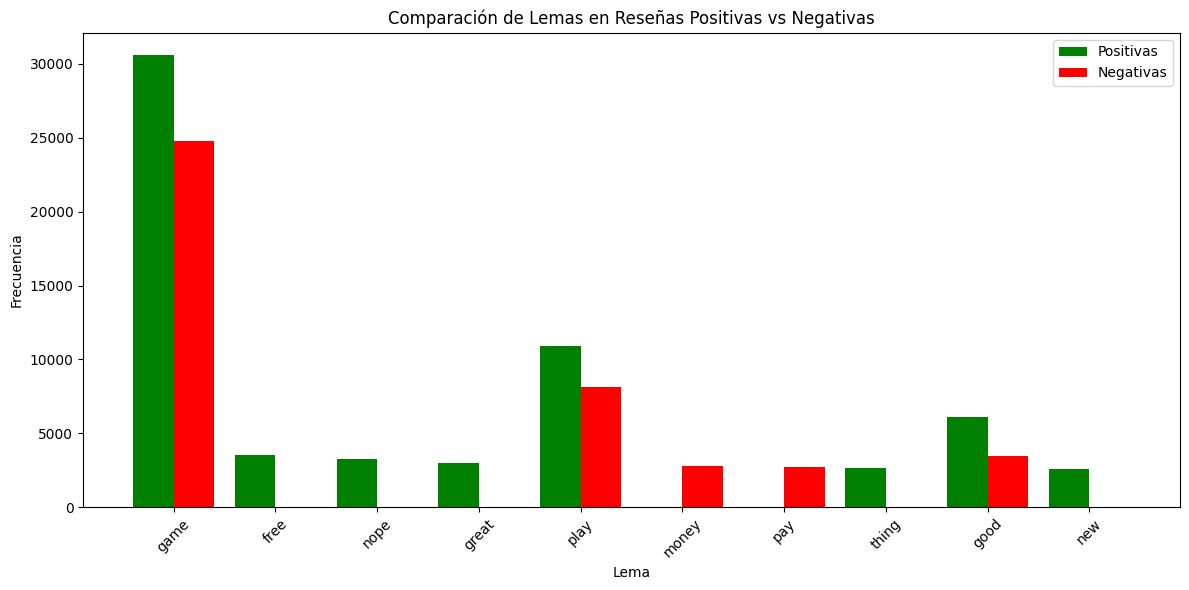

In [21]:
#Visualizar con gráfico de barras
import matplotlib.pyplot as plt

# Visualización
plt.figure(figsize=(12,6))
bar_width = 0.4
x = range(len(top_lemmas))

plt.bar(x, top_lemmas['freq_pos'], width=bar_width, label='Positivas', color='green')
plt.bar([i + bar_width for i in x], top_lemmas['freq_neg'], width=bar_width, label='Negativas', color='red')

plt.xticks([i + bar_width/2 for i in x], top_lemmas['word'], rotation=45)
plt.xlabel('Lema')
plt.ylabel('Frecuencia')
plt.title('Comparación de Lemas en Reseñas Positivas vs Negativas')
plt.legend()
plt.tight_layout()
plt.show()


Removemos la palabra game
La palabra game en este data set aparece en ambos casos, positivos y negativos porque de lo que estamos hablando es de juegos.
No quiero que considere la palabra game por lo que voy a agregarla en una lista de stopwords para poder excluirla de mi análisis.

. Crear la lista original de stopwords
. Agregar palabras que querés excluir (como 'game', 'games')

In [26]:
#from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


In [27]:
# usamos update() para agregar múltiples palabras
stop_words.update(['game', 'games'])


In [28]:
# Limpieza actualizada
#import re
#from nltk.tokenize import word_tokenize

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Elimina signos de puntuación
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [29]:
#Aplicamos nuevamente al dataframe
train_df['clean_review'] = train_df['user_review'].apply(clean_text)


In [30]:
#Verifico como quedó
all("game" not in review for review in train_df["clean_review"])



False

In [32]:
# Verificamos
train_df[['user_review', 'clean_review']].head(25)

,user_review,clean_review
0,I'm scared and hearing creepy voices. So I'll...,im scared hearing creepy voices ill pause mome...
1,"Best game, more better than Sam Pepper's YouTu...",best better sam peppers youtube account youll ...
2,"A littly iffy on the controls, but once you kn...",littly iffy controls know play easy master ive...
3,"Great game, fun and colorful and all that.A si...",great fun colorful thata side note though gett...
4,Not many games have the cute tag right next to...,many cute tag right next horror tag steami fir...
5,"Early Access ReviewIt's pretty cute at first, ...",early access reviewits pretty cute first later...
6,Great game. it's a cute little horror game tha...,great cute little horror progressively gets da...
7,Spooky's Jump Scare Mansion is a Free Retro ma...,spookys jump scare mansion free retro maze jum...
8,"Somewhere between light hearted, happy parody ...",somewhere light hearted happy parody afraid da...
9,This game with its cute little out of the wall...,cute little wall popups scared living light li...


In [33]:
# Buscar reseñas que aún contienen la palabra 'game'
train_df[train_df['clean_review'].str.contains(r'\bgame\b')]


,review_id,title,year,user_review,user_suggestion,lowercase,no_punct,tokens,no_stopwords,clean_review


In [34]:
#revisamos nuevamente todo
from collections import Counter


# Recontamos lemas por clase
pos_tokens = ' '.join(train_df[train_df['user_suggestion'] == 1]['clean_review']).split()
neg_tokens = ' '.join(train_df[train_df['user_suggestion'] == 0]['clean_review']).split()

# Conteo
pos_counts = Counter(pos_tokens).most_common(15)
neg_counts = Counter(neg_tokens).most_common(15)

# Convertir a DataFrames
df_pos = pd.DataFrame(pos_counts, columns=['word', 'freq_pos'])
df_neg = pd.DataFrame(neg_counts, columns=['word', 'freq_neg'])

# Unir por palabra
merged_freq = pd.merge(df_pos, df_neg, on='word', how='outer').fillna(0)
merged_freq['freq_pos'] = merged_freq['freq_pos'].astype(int)
merged_freq['freq_neg'] = merged_freq['freq_neg'].astype(int)
merged_freq['diff'] = merged_freq['freq_pos'] - merged_freq['freq_neg']
merged_freq['abs_diff'] = merged_freq['diff'].abs()

# Seleccionar las más polarizadas
top_words = merged_freq.sort_values(by='abs_diff', ascending=False).head(10)


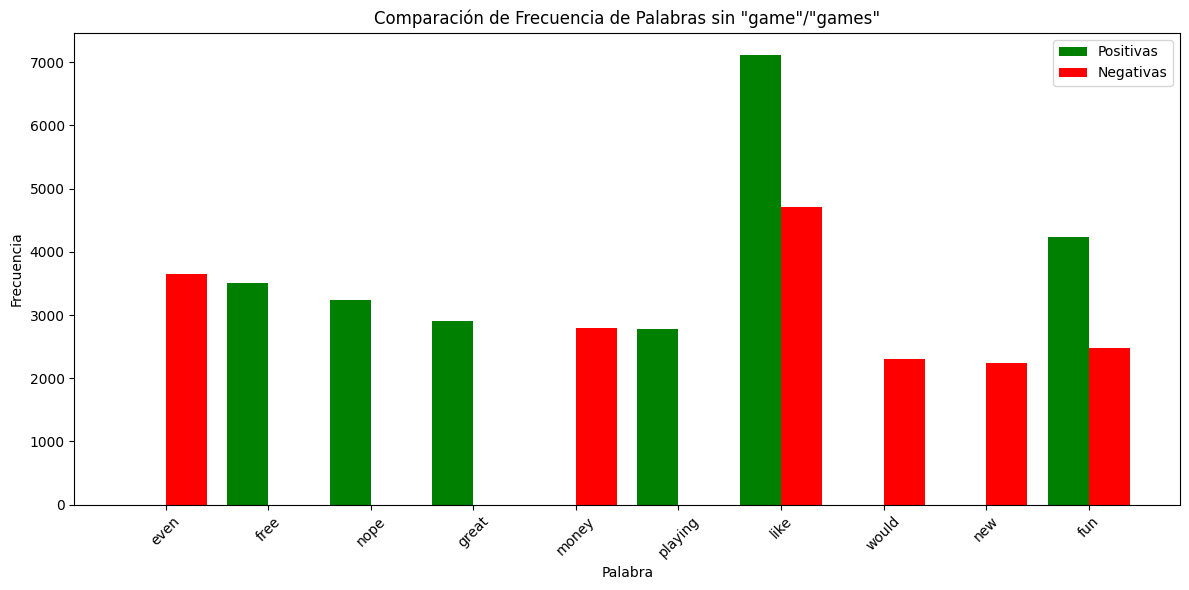

In [35]:
# Gráfico de barras
plt.figure(figsize=(12,6))
bar_width = 0.4
x = range(len(top_words))

plt.bar(x, top_words['freq_pos'], width=bar_width, label='Positivas', color='green')
plt.bar([i + bar_width for i in x], top_words['freq_neg'], width=bar_width, label='Negativas', color='red')

plt.xticks([i + bar_width/2 for i in x], top_words['word'], rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Comparación de Frecuencia de Palabras sin "game"/"games"')
plt.legend()
plt.tight_layout()
plt.show()


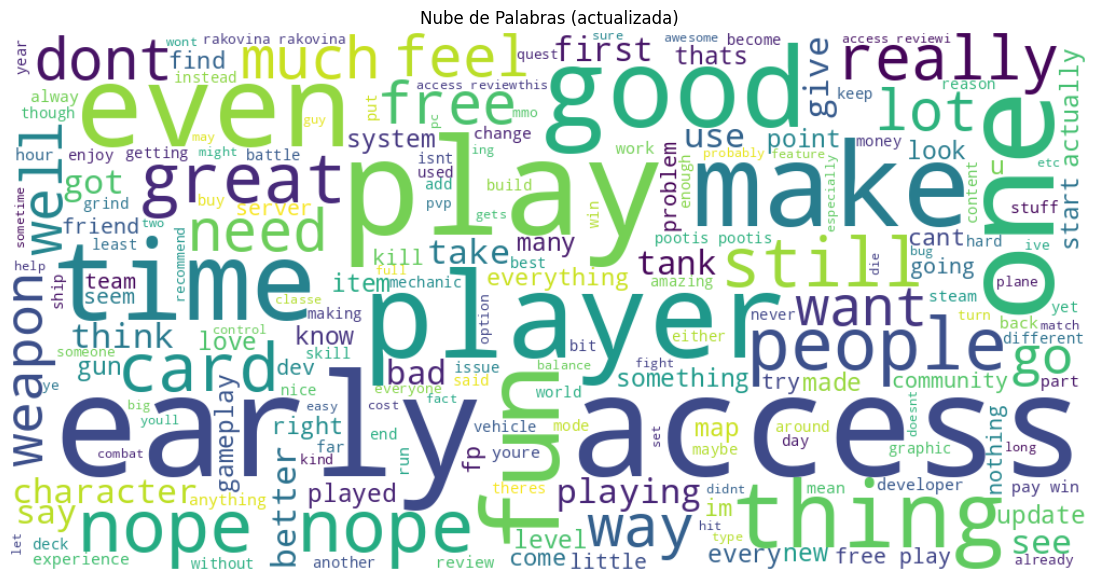

In [36]:
from wordcloud import WordCloud

# Texto combinado limpio
text = ' '.join(train_df['clean_review'])

# Generar WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)

# Mostrar
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras (actualizada)')
plt.show()


# Modelo de Deep Learning

Vamos a preparar un modelo usando Keras (con TensorFlow backend).


## Red Neuronal Sencilla

Preparar datos con Tokenizer de Keras

Rellenar secuencias con pad_sequences

Definir arquitectura de red neuronal

Entrenar y evaluar

(Opcional) Mostrar curvas de aprendizaje



In [ ]:
# transformar tu texto limpio (clean_review) en un formato numérico compatible con una red neuronal en Keras.


In [ ]:
# Importar y configurar Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np


In [ ]:
# Definir parámetros
MAX_NUM_WORDS = 10000  # Máximo vocabulario a considerar
MAX_SEQUENCE_LENGTH = 100  # Longitud máxima de cada reseña (relleno o truncamiento)


In [ ]:
#Tokenizar el texto
# Inicializamos
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')

# Entrenamos
tokenizer.fit_on_texts(train_df['clean_review'])

# Convertimos los textos a secuencias numéricas
sequences = tokenizer.texts_to_sequences(train_df['clean_review'])

# Rellenamos las secuencias a longitud fija
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Etiquetas (ya están como 0 o 1)
y = train_df['user_suggestion'].values


In [ ]:
#División en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Definición y entrenamiento del modelo


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Parámetros clave
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_SEQUENCE_LENGTH = 100

# Definición del modelo
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [ ]:
# Entrenamos con EarlyStopping para evitar overfitting
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6048 - loss: 0.6691 - val_accuracy: 0.8194 - val_loss: 0.5266
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8143 - loss: 0.4565 - val_accuracy: 0.8365 - val_loss: 0.3875
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8578 - loss: 0.3370 - val_accuracy: 0.8411 - val_loss: 0.3665
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8792 - loss: 0.2992 - val_accuracy: 0.8071 - val_loss: 0.4247
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8901 - loss: 0.2686 - val_accuracy: 0.8457 - val_loss: 0.3604
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9101 - loss: 0.2338 - val_accuracy: 0.8502 - val_loss: 0.3607
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9128 - loss: 0.2255 - val_accuracy: 0.8488 - val_loss: 0.3710


## Visualización de curvas de aprendizaje

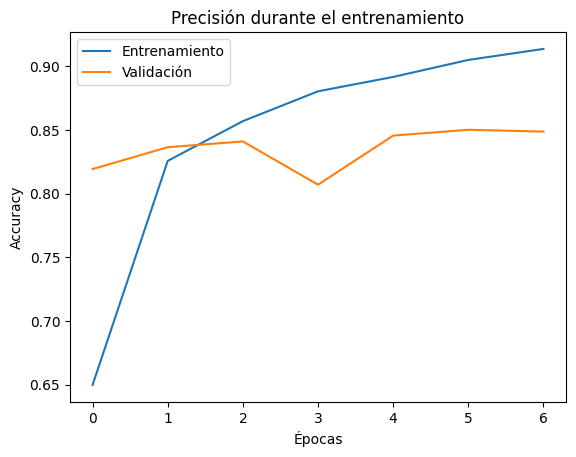

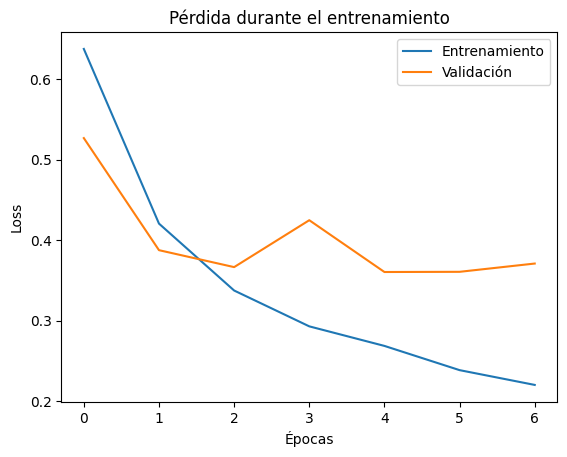

In [ ]:


# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluar el modelo de Deep Learning

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1473
           1       0.84      0.91      0.87      2026

    accuracy                           0.85      3499
   macro avg       0.85      0.83      0.84      3499
weighted avg       0.85      0.85      0.84      3499



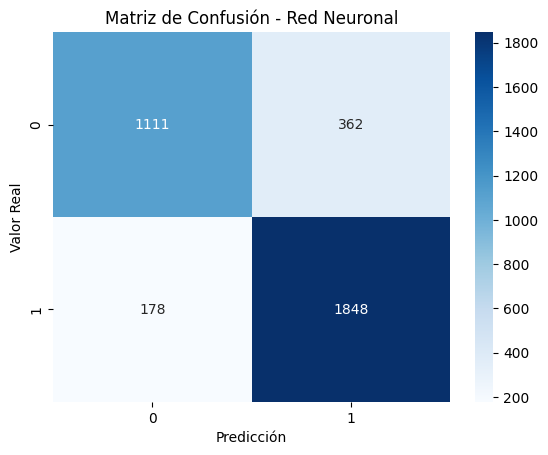

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predecir sobre X_val
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Reporte de clasificación
print(classification_report(y_val, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Red Neuronal")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


## N-gramas con CountVectorizer


In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_ngrams = CountVectorizer(ngram_range=(1,2))
# Corrected the DataFrame and column name to use the preprocessed text
X_ngrams = vectorizer_ngrams.fit_transform(train_df['clean_review'])

print("Shape de la matriz n-gramas:", X_ngrams.shape)

Shape de la matriz n-gramas: (17494, 798032)


Top 10 n-gramas más frecuentes:


,N-grama,Frecuencia
0,like,11824
1,play,11343
2,get,11306
3,good,7489
4,dont,7322
5,time,7177
6,early,6893
7,access,6875
8,one,6779
9,fun,6699


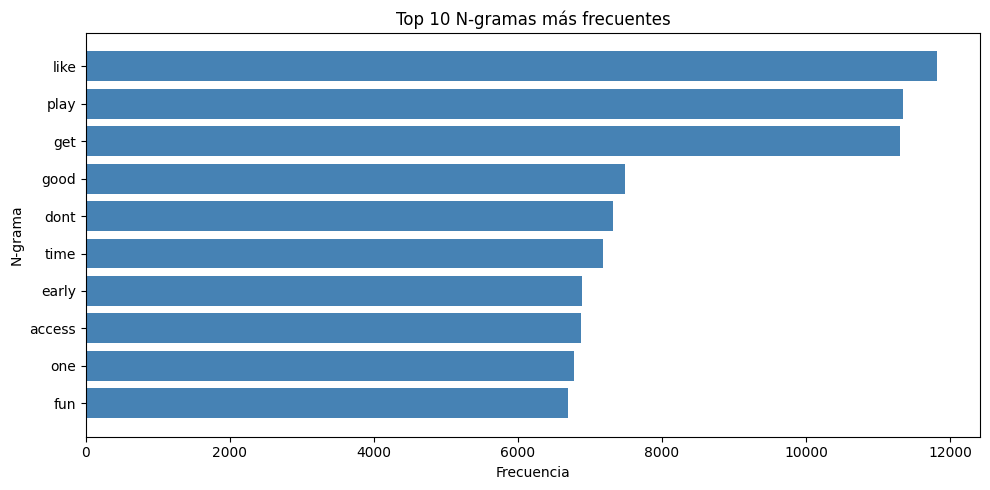

In [39]:
# Visualización de los 10 n-gramas más frecuentes

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Crear el vectorizador de n-gramas (unigramas + bigramas)
vectorizer_ngrams = CountVectorizer(ngram_range=(1,2))
X_ngrams = vectorizer_ngrams.fit_transform(train_df['clean_review'])

# Calcular la frecuencia total de cada n-grama
sum_words = X_ngrams.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer_ngrams.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Convertir a DataFrame y tomar los 10 más frecuentes
df_freq = pd.DataFrame(words_freq[:10], columns=['N-grama', 'Frecuencia'])

# Mostrar la tabla
print("Top 10 n-gramas más frecuentes:")
display(df_freq)

# Visualización con gráfico de barras
plt.figure(figsize=(10,5))
plt.barh(df_freq['N-grama'][::-1], df_freq['Frecuencia'][::-1], color='steelblue')
plt.title("Top 10 N-gramas más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.tight_layout()
plt.show()


## Análisis de sentimiento con TextBlob

Aplicar un análisis de sentimiento utilizando TextBlob, para transformar comentarios textuales en etiquetas binarias (positivo/negativo) para su posterior uso en tareas de clasificación supervisada

In [41]:
from textblob import TextBlob

# Corrected the DataFrame and column name
train_df['sentiment_polarity'] = train_df['user_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['sentiment_label'] = train_df['sentiment_polarity'].apply(lambda x: 1 if x > 0 else 0)

train_df[['user_review', 'sentiment_polarity', 'sentiment_label']].head()


,user_review,sentiment_polarity,sentiment_label
0,I'm scared and hearing creepy voices. So I'll...,-0.028125,0
1,"Best game, more better than Sam Pepper's YouTu...",0.228571,1
2,"A littly iffy on the controls, but once you kn...",0.018193,1
3,"Great game, fun and colorful and all that.A si...",0.354167,1
4,Not many games have the cute tag right next to...,0.045408,1


## Conversión binaria del puntaje

In [45]:
print(games_df.columns)
print(games_df['User score'].unique())


Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')
[  0  63  59  77  68 100  57  80  51  69  97  53  46  65  55  84  71  60
  61  78  87  92  73  83  82  98  76  66  95  94  96  88  70]


In [46]:
# Conversión binaria del puntaje desde 'User score'
games_df = games_df.dropna(subset=['User score'])

In [47]:
# Crear variable binaria: 1 si el puntaje es >= 70, 0 en caso contrario
games_df['binary_score'] = games_df['User score'].astype(int).apply(lambda x: 1 if x >= 70 else 0)

<Axes: title={'center': 'Distribución de puntuación binaria'}, xlabel='binary_score'>

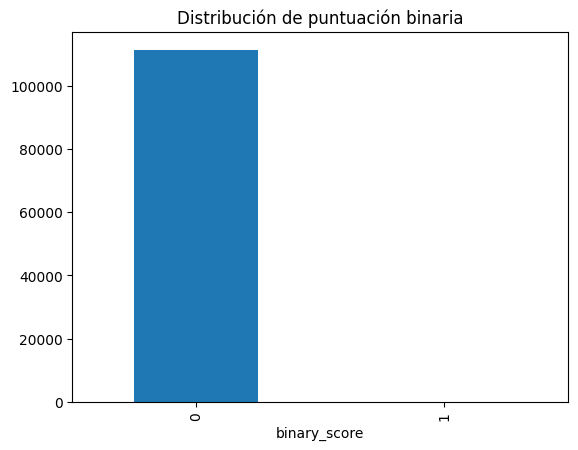

In [48]:
# Ver distribución
games_df['binary_score'].value_counts().plot(kind='bar', title='Distribución de puntuación binaria')


## Resumen

Se realizó limpieza y normalización del texto.

Se eliminaron stopwords, se tokenizó y se creó una columna clean_review.

Se aplicó la vectorización TF-IDF, generando representaciones numéricas interpretables.

Se utilizó Logistic Regression como modelo de clasificación.

El modelo alcanzó una accuracy del 85%, con buen desempeño en ambas clases.

Las métricas F1 y la matriz de confusión confirmaron que no hay sesgo relevante hacia una clase.

Se generaron nubes de palabras por clase (user_suggestion = 0 o 1).

Se detectaron términos ambiguos como "nope" que aparecen en ambas clases, lo que sugiere casos de ironía o polaridad mal clasificada.

Se identificaron palabras más frecuentes que aportan insight sobre las opiniones reales de los usuarios.


# Conclusión

## Limitaciones detectadas:

* Algunas palabras clave influyen negativamente en los resultados por malinterpretaciones del contexto.

* El desbalance de registros en algunas categorías puede necesitar técnicas como oversampling en futuros modelos.

## Posibilidades de mejora:

* Probar con modelos más complejos como Random Forest, SVM o redes neuronales.
* Analizar el texto de los juegos (overview) como variable complementaria para clusterizar juegos según estilo y género.

## Cierre
Se logró construir un modelo que clasifica automáticamente las reseñas de juegos de Steam como positivas o negativas, usando técnicas de procesamiento de lenguaje natural y regresión logística.
